<a href="https://colab.research.google.com/github/DouglasPaulino99/power-consumption-cluster/blob/main/power_consumption_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consumo de energia**

<img src="http://www.mesanusa.com/wp-content/uploads/2012/06/137593586.jpg" width="40%"></p>

Em Março de 2022, o Brasil bateu [recorde de consumo de energia elétrica](https://www.cnnbrasil.com.br/business/brasil-teve-recorde-historico-de-consumo-de-energia-em-marco-aponta-epe/). O detalhe é que o momento era de uma crise hídrica, principal fonte geradora de energia do país.

Diante desses dois fatores conflitantes, entender um pouco sobre o perfil dos consumidores é fundamental para que se tome decisões acerca de campanhas publicitárias de conscientização, ajuste de preços, etc. E uma ótima forma de fazer, é utilizando as tecnicas de *clustering*.

*Clustering* é uma técnica de agrupamento de dados baseado em comportamento semelhante. Diferente do que se tem costume, não há uma resposta certa ou errada para a rede neural, portanto, o dataset é agrupado conforme o algoritmo decidir.

É importante ressaltar, que nessa técnica, o label será criado, e não entregue, conforme ocorre no aprendizado supervisionado. Portanto, pode-se dizer que o *Clustering* é o meio e não o fim.


# **Dados**

Será utilizado o Individual household electric power consumption Data Set fornecido pelo [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption), que pegou dados a cada 1 minuto durante 4 anos dos clientes em Sceaux, na França.

Segundo informação do dataset, ele apresenta os parâmetros:

* **date**: Data no formato dd/mm/yyyy
* **time**: Tempo no formato hh:mm:ss
* **global_active_power**: potência ativa média global doméstica por minuto (em quilowatts)
* **global_reactive_power**: potência reativa média global doméstica por minuto (em quilowatts)
* **voltage**: Tensão Média por minuto (Em Volts)
* **global_intensity**: intensidade de corrente média global doméstica por minuto (em amperes)
* **sub_metering_1**: Subdivisão para a cozinha, contendo lava louças, fogão elétrico e microondas (Em Watt Hora)
* **sub_metering_2**: Subdivisão para a lavanderia que contem máquina de lavar, lâmpada, geladeira e secadora (Em Watt Hora)
* **sub_metering_3**: Subdivisão para aquecedor de água e ar condicionado (Em Watt Hora)

O objetivo desse projeto é identificar e agrupar os perfis de clientes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
file = '/content/drive/MyDrive/datasets/household-power-consumption/household_power_consumption.txt'

dataset = pd.read_csv(file, delimiter = ';', low_memory= False) #Low memory pq o arquivo é grande

# **Análise do dataset**
Inicialmente, veremos a cara do dataset, analisando as colunas, o tamanho, formato dos dados, etc.

Em seguida, fazemos a limpeza, removendo a coluna de tempo e data e os dados nulos.

In [3]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
dataset.shape

(2075259, 9)

In [5]:
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [6]:
dataset.info() #Muito melhor que usar as opções anteriores por ser compacto em 1 só comando

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
dataset.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [8]:
print('{:.3f}% de NaN'.format(dataset.Sub_metering_3.isnull().sum()/(dataset.Sub_metering_3.count())))

0.013% de NaN


In [9]:
dataset = dataset.dropna()
dataset.isnull().count()




Date                     2049280
Time                     2049280
Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

In [10]:
dataset = dataset.iloc[0:, 2:9]
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [11]:
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [12]:
dataset_atrib = dataset.values

In [13]:
dataset, amostra2 = train_test_split(dataset_atrib, train_size = 0.01)
dataset.shape


(20492, 7)

# **Modelo**
Vamos caracterizar o nosso modelo

## **PCA**
Fazemos uma redução de dimensionalidade a partir da variância, aproveitando todas as colunas.

In [14]:
pca = PCA(n_components=2).fit_transform(dataset)

In [ ]:
k_range = range(1,12)
k_range

range(1, 12)

In [ ]:
k_means_var = [KMeans(n_clusters=k).fit(pca) for k in k_range] #célula pesada pois ela cria "k_range" valores preditivos

## **Curva de Elbow**

Vamos fazer na mão uma curva de Elbow para identificar o número adequado de clusters

Text(0.5, 1.0, 'Variância explicada para cada valor de K')

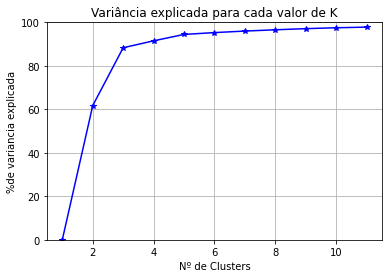

In [ ]:
centroids = [X.cluster_centers_ for X in k_means_var] #centroide é o centro de cada grupo

k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids] #Distancia euclidiana 
dist = [np.min(ke, axis = 1) for ke in k_euclid]

soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

soma_total = sum(pdist(pca)**2)/pca.shape[0]

soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

#Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Nº de Clusters')
plt.ylabel('%de variancia explicada')
plt.title('Variância explicada para cada valor de K')

A partir de 8 clusters, a curva começa a estabilizar, então usamos o silhouette score como métrica para ver o melhor número.

**Modelo com K=8**

In [ ]:
modelo_v1 =  KMeans(n_clusters = 8)
modelo_v1.fit(pca) 

KMeans()

In [ ]:
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean') #1 = bom, -1 = ruim

0.7902285221224209

**Modelo com K = 9 **

In [ ]:
modelo_v2 =  KMeans(n_clusters = 9)
modelo_v2.fit(pca) 

labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean') #1 = bom, -1 = ruim

0.6133065036957633

**Modelo com K = 10 **

In [ ]:
modelo_v3 =  KMeans(n_clusters = 10)
modelo_v3.fit(pca) 

labels = modelo_v3.labels_
silhouette_score(pca, labels, metric = 'euclidean') #1 = bom, -1 = ruim

0.6322520394426687

**Modelo com K = 11**

In [ ]:
modelo_v4 =  KMeans(n_clusters = 11)
modelo_v4.fit(pca) 

labels = modelo_v4.labels_
silhouette_score(pca, labels, metric = 'euclidean') #1 = bom, -1 = ruim

0.5986335720778867

A partir dessa análise, vemos que K = 8 é o número adequado.

## **Utilizando outro método**

A partir de uma biblioteca pronta, vamos verificar o número de clusters para poder comparar qual dos dois métodos é o mais adequado.

In [15]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [16]:

df = pd.DataFrame(pca)
df

,0,1
0,-7.394933,0.709579
1,-6.491341,0.296840
2,9.263512,-6.443427
3,-6.413483,0.596492
4,-4.150241,2.632276
...,...,...
20487,-6.418886,1.279030
20488,14.333318,-2.510266
20489,9.840650,-4.666988
20490,-8.223849,0.229015


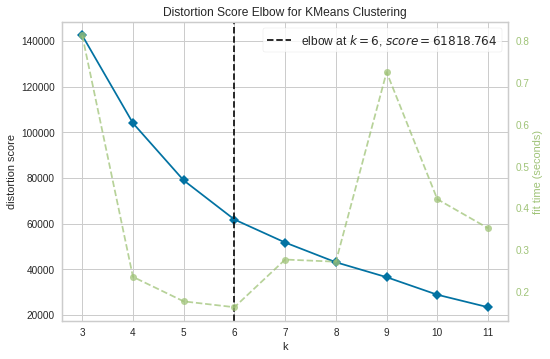

In [17]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(3,12)) #k = grupos

data_sample = df.sample(n=10000, random_state=1)

visualizer.fit(data_sample)
visualizer.poof()

Segundo o método, K = 6 é melhor. Vamos comparar com o resultado obtido anteriormente (K = 8)

**K = 6**

In [26]:
kmeans6 = KMeans(n_clusters=6)
k_fit6 = kmeans6.fit(df)

predict6 = k_fit6.labels_

silhouette_score(df, predict6, metric = 'euclidean') #1 = bom, -1 = ruim

0.8529441778891454

**K = 8**

In [27]:
kmeans8 = KMeans(n_clusters=8)
k_fit8 = kmeans8.fit(df)

predict8 = k_fit8.labels_
#df['Clusters'] = predict  

silhouette_score(df, predict8, metric = 'euclidean') #1 = bom, -1 = ruim

0.8067288949933609

De fato, K = 6 é melhor.

# **Usando os resultados**
Tendo o resultado ideal para o número de clusters, podemos agora fazer a mudança no dataset conforme queremos. No caso, iremos prepará-lo para que seja feita uma análise posterior, já que agora há a presença de um label

In [20]:
title = pd.read_csv(file, delimiter = ';', index_col=0, nrows=0) #Ler só cabeçalho 

title = title.iloc[:,1:9].columns.tolist() # remover as duas primeiras colunas e passar o resto pra uma lista
title

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [28]:
cluster_map = pd.DataFrame(dataset, columns = title)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = predict6
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.410,0.074,241.830,1.800,0.000,0.000,0.0,0
1,0.338,0.206,240.780,1.600,0.000,0.000,1.0,0
2,1.326,0.000,242.150,5.400,0.000,0.000,18.0,3
3,0.474,0.254,243.330,2.200,0.000,1.000,1.0,0
4,2.422,0.000,243.130,9.800,0.000,0.000,0.0,0
...,...,...,...,...,...,...,...,...
20487,0.748,0.056,238.600,3.000,0.000,0.000,0.0,0
20488,4.182,0.394,237.200,17.600,0.000,0.000,17.0,3
20489,1.738,0.260,240.150,7.200,0.000,2.000,17.0,3
20490,0.302,0.098,245.890,1.200,0.000,0.000,0.0,0


In [22]:
cluster_map.groupby('cluster')['Global_active_power'].mean().sort_values(ascending=False)

cluster
2    4.652972
6    3.791371
4    3.473923
5    2.573143
0    2.361855
3    1.814714
7    1.143135
1    0.512432
Name: Global_active_power, dtype: float64

# **Conclusões**

Clustering é uma boa técnica para agrupar perfis para que sejam feitas outras análises e o KElbowVisualizer é uma boa ferramenta para analisar a quantidade necessária dos clusters.

O algoritmo conseguiu identificar os grupos sem que nenhuma outra informação fosse passada e o teste foi concluido com sucesso.
